# Homework 2
CSCI 5636  
Andrew Altomare

We've seen in class how to employ Chebyshev methods to construct linear operators for approximating derivatives. Let $D_i$ be the linear operator whose action approximates the $i^{th}$ derivative. Now consider the following second order linear ODE:

$$ u''(t)+au'(t)+bu(t) = f(t) $$

We can rewrite this as

$$\begin{align*}
D_2u + aD_1u+bD_0u &= f \\ 
(D_2+aD_1+bD_0)u &= f
\end{align*}$$

where $D_0$ is the identity. The sum of scaled linear operators is, of course, itself a linear operator. So now, recovering $u$ amounts to a simple linear solve. Below are some functions from lecture to set up Chebyshev spectral collocation over a cosine spaced grid.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def vander_chebyshev(x, n=None):
    """Build Vandermonde matrix with Chebyshev polynomial basis"""
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = np.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = np.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = np.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (np.cos(np.linspace(-np.pi, 0, n)))

Let $V_i$ be the Chebyshev Vandermonde matrix generated above associated with the $i^{th}$ derivative, and $c$ be the set of coefficients such that $V_0c=u$. Then the $i^{th}$ derivative of $u$ is approximated with $u^{(i)}\approx V_ic$. Now we have 

$$ D_i = V_iV_0^{-1}\ \ \Rightarrow\ \ D_2+aD_1+bD_0 = (V_2 + aV_1 + bV_0)V_0^{-1}$$

Let $L = (V_2 + aV_1 + bV_0)V_0^{-1}$. The function below, $\texttt{ode_cheb}$, returns $L$ for a given set of coefficients $a,b$.

Dirichlet and Neumann boundary conditions constrain the matrix $L$. Both are both applied to the 'left' boundary. The Dirichlet condition replaces the first row in $L$ and the Neumann condition replaces the last row in $L$.

In [132]:
def ode_cheb(n, rhsfunc, leftD, leftN, coef=(1,1)):
    """Solve the boundary value problem on (0,1) using n elements with rhsfunc(x) forcing.
    The two left boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)"""
    a, b = coef # unpack coefficient tuple
    x = cosspace(-1, 1, n)  # n+1 points is n "elements"
    T = chebeval(x)
    L = T[2] + a*T[1] + b*T[0]
    rhs = rhsfunc(x)
    for i,deriv,func in [(0, *leftD), (-1, *leftN)]:
        L[i] = T[deriv][0]
        rhs[i] = func(x[0])
    return x, L.dot(np.linalg.inv(T[0])), rhs

### Example solution
Below is a demonstration of the described method solving a manufactured solution with $u(x)=5\tanh(x-0.3)$ and forcing term

$$ f(x) = u''(x) + 5u'(x) + 10u(x) $$

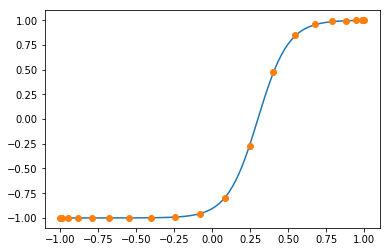

In [135]:
class exact_tanh:
    def __init__(self, k=1, x0=0, coef=(1,1)):
        self.k = k
        self.x0 = x0
        self.a, self.b = coef
    def u(self, x):
        return np.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * np.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * np.tanh(self.k*(x - self.x0)) * np.cosh(self.k*(x - self.x0))**(-2)
    def f(self, x):
        return self.b*self.u(x) + self.a*self.du(x) + self.ddu(x)
    
xx = np.linspace(-1,1,100)
ex = exact_tanh(5,0.3,(5,10))
x, L, f = ode_cheb(20, ex.f, leftD=(0,ex.u), leftN=(1,ex.du), coef=(5,10))
u = np.linalg.solve(L, f)
plt.plot(xx,ex.u(xx))
plt.plot(x,u, 'o')

### Grid refinement study
We observe spectral convergence.

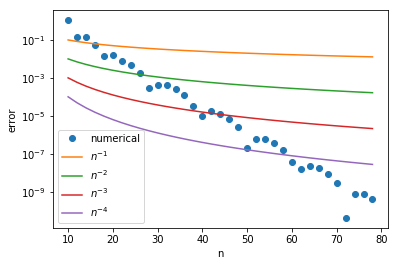

In [75]:
def mms_error(n, discretize, sol):
    x, L, f = discretize(n, lambda x: sol.f(x), leftD=(0,sol.u), leftN=(1,sol.du))
    u = np.linalg.solve(L, f)
    return np.linalg.norm(u - sol.u(x), np.inf)

ns = np.arange(10,80,2)
errors = [mms_error(n, ode_cheb, ex) for n in ns]
plt.figure()
plt.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    plt.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
plt.xlabel('n')
plt.ylabel('error')
    
plt.legend(loc='lower left');

Experimenting with different values of $a$ and $b$, we see that having $a<<b$ produces a very high frequency function, whereas other variations yield something much smoother.

We know that a solution to the second order linear ODE

$$ u''(x) + au'(x) + bu(x) = 0 $$

is given by $u(x) = e^{rx}$ for some $r$. Substituting, we get

$$\begin{align*}
0 &= r^2e^{rx} + are^{rx} + be^{rx} \\
0 &= e^{rx}(r^2 + ar + b) \\
\Rightarrow 0 &= r^2 + ar + b
\end{align*}$$

If $a<<b$, then $r\in\mathbb{C}$ with a significant imaginary part, which intuitively, should give a high frequency $u$.

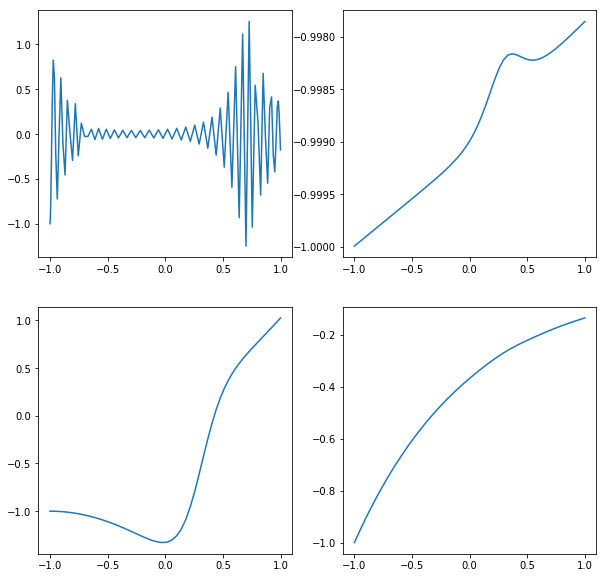

In [130]:
f = lambda x: 0*x
dirichlet = lambda x: 0*x + 1 # ode_cheb takes boundary conditions as functions
neumann = lambda x: 0*x
coef_mesh = [(10,10000), (10000,10), (.1,.1), (1000,1000)] #different values of coefficients (a,b)
plt.figure(figsize=(10,10))
for i,c in enumerate(coef_mesh):
    x, L, f = ode_cheb(80, ex.f, leftD=(0,ex.u), leftN=(1,ex.du), coef=c)
    u = np.linalg.solve(L, f)
    plt.subplot(2,2,i+1)
    plt.plot(x,u)